In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import urllib.request
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage


In [23]:
#Download the file
url = "https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip"
file_name = "cats_and_dogs.zip"

# Add a User-Agent header to the request
headers = {'User-Agent': 'Mozilla/5.0'}
request = urllib.request.Request(url, headers=headers)

# Download the file
with urllib.request.urlopen(request) as response, open(file_name, 'wb') as out_file:
    data = response.read()  # a `bytes` object
    out_file.write(data)

#Unzip the file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    for member in zip_ref.namelist():
        # Extract members to the current directory, omitting any nested 'cats_and_dogs' directory
        zip_ref.extract(member, '.')



In [3]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
# Check the content of the extracted directory 
extracted_dir = 'cats_and_dogs'
print("Contents of extracted directory:", os.listdir(extracted_dir))

Contents of extracted directory: ['.DS_Store', 'test', 'train', 'validation']


In [5]:
# 3 and # 5
train_image_generator = ImageDataGenerator(rescale = 1./255,
                                           rotation_range = 40,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip = True
                                           )
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(directory = train_dir,
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode = "rgb",
                                                           batch_size = batch_size,
                                                           class_mode = "binary",
                                                           shuffle = True)
val_data_gen = validation_image_generator.flow_from_directory(directory = validation_dir,
                                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode = "rgb",
                                                              batch_size = batch_size,
                                                              class_mode = "binary",
                                                              shuffle = True)

#For the test data, since the flow_from_directory expects at list a subdirectory, I have create one and passed the images there
test_data_gen = test_image_generator.flow_from_directory(directory = test_dir,
                                                         target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         color_mode = "rgb",
                                                         batch_size = 1,
                                                         class_mode = None,
                                                         shuffle = False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


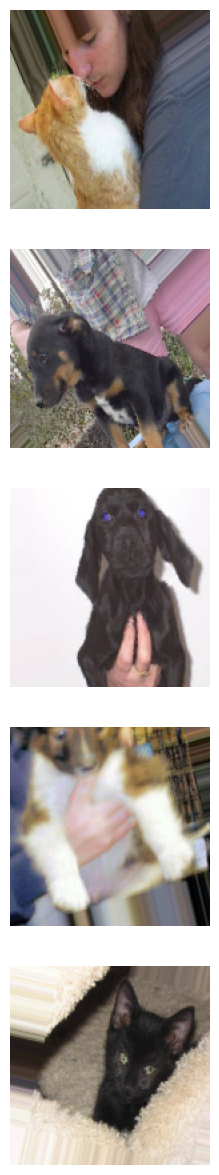

In [6]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Found 2000 images belonging to 2 classes.


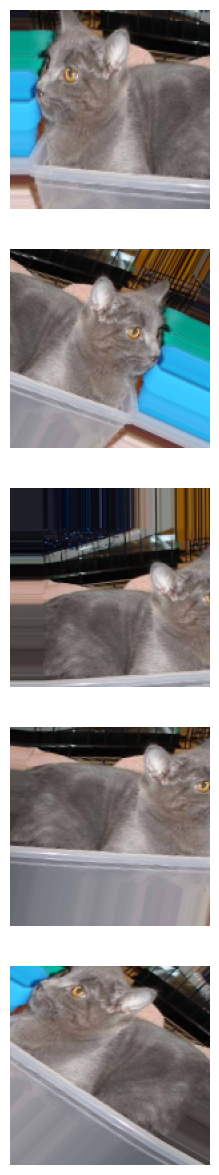

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [8]:
# 7
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(256, (3, 3), activation ='relu'))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid')) #It only needs 1 output unit with a sigmoid function. If the value is >=0.5 it's classifies as a dog, if it's <0.5 it classifies as a cat


model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy', #Because it's a binary classification
              metrics = ['accuracy'])



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [9]:
# 8
history = model.fit(train_data_gen,
                    steps_per_epoch=len(train_data_gen),
                    epochs = 15,
                    validation_data = val_data_gen,
                    validation_steps = len(val_data_gen))

Epoch 1/15
16/16 [==============================] - 60s 4s/step - loss: 0.6966 - accuracy: 0.4975 - val_loss: 0.6911 - val_accuracy: 0.6150
Epoch 2/15
16/16 [==============================] - 63s 4s/step - loss: 0.6886 - accuracy: 0.5575 - val_loss: 0.6831 - val_accuracy: 0.5010
Epoch 3/15
16/16 [==============================] - 65s 4s/step - loss: 0.6825 - accuracy: 0.5680 - val_loss: 0.6825 - val_accuracy: 0.5570
Epoch 4/15
16/16 [==============================] - 64s 4s/step - loss: 0.6837 - accuracy: 0.5510 - val_loss: 0.6777 - val_accuracy: 0.5350
Epoch 5/15
16/16 [==============================] - 53s 3s/step - loss: 0.6569 - accuracy: 0.6055 - val_loss: 0.6472 - val_accuracy: 0.6090
Epoch 6/15
16/16 [==============================] - 54s 3s/step - loss: 0.6473 - accuracy: 0.6180 - val_loss: 0.6393 - val_accuracy: 0.5990
Epoch 7/15
16/16 [==============================] - 55s 3s/step - loss: 0.6559 - accuracy: 0.6100 - val_loss: 0.6257 - val_accuracy: 0.6240
Epoch 8/15
16/16 [==

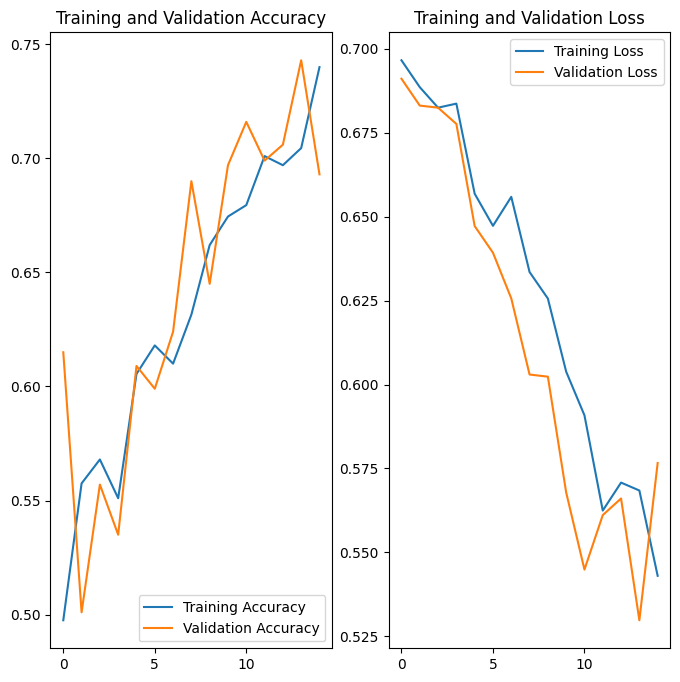

In [10]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 [==============================] - 0s 87ms/step


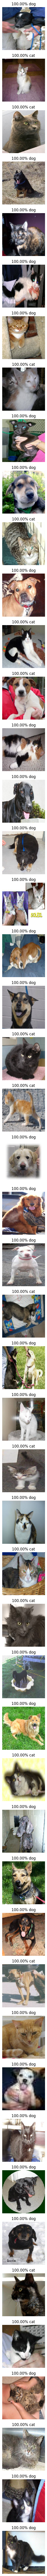

In [11]:
# Get all the test images from the generator
test_images = []

# Loop over the test generator to collect all the images
for i in range(len(test_data_gen)):
    images = next(test_data_gen)  # No labels, so just grab the images
    test_images.append(images)

# Convert the list of image batches to a single array of images
test_images = np.concatenate(test_images)

# Make predictions on all the test images
probabilities = np.round(model.predict(test_images))

# Plot all test images with their predicted probabilities
plotImages(test_images, probabilities)

In [12]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
